<a href="https://colab.research.google.com/github/VSUrhuel/forage-classifier/blob/main/training_without_pre_trained_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [60]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.layers import Dropout, Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense
from keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from google.colab import drive
import cv2
import random
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [61]:
drive.mount('/content/drive')
path_to_dataset = '/content/drive/MyDrive/Thesis/Dataset'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [62]:
classes = ['carabao-grass', 'centro', 'gliricidia', 'leucaena', 'para-grass']

X_train, Y_train = [], []
is_augmented = []
X_val, Y_val = [], []
X_test, Y_test = [], []

def assign_index_label(forage_type):
  forage_type = forage_type.lower()
  if forage_type in classes:
    return classes.index(forage_type)
  else:
    print("Unrecognized forage label")
    return -1

In [63]:
def load_dataset_from_folder(path, X, Y):
  for forage_type in os.listdir(path):
    forage_path = os.path.join(path, forage_type)

    label = assign_index_label(forage_type)
    for image in os.listdir(forage_path):
      image_path = os.path.join(forage_path, image)\

      image = cv2.imread(image_path)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      image = cv2.resize(image, (224, 224))
      image = image / 255.0

      if(image_path.find('aug') != -1):
        is_augmented.append(True)
      else:
        is_augmented.append(False)
      X.append(image)
      Y.append(label)

In [64]:
train_dir = os.path.join(path_to_dataset, 'train')
val_dir = os.path.join(path_to_dataset, 'val')
test_dir = os.path.join(path_to_dataset, 'test')

load_dataset_from_folder(train_dir, X_train, Y_train)
load_dataset_from_folder(val_dir, X_val, Y_val)
load_dataset_from_folder(test_dir, X_test, Y_test)

X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_val = np.array(X_val)
Y_val = np.array(Y_val)
X_test = np.array(X_test)
Y_test = np.array(Y_test)

Y_train = to_categorical(Y_train, len(classes))
Y_val = to_categorical(Y_val, len(classes))
Y_test = to_categorical(Y_test, len(classes))

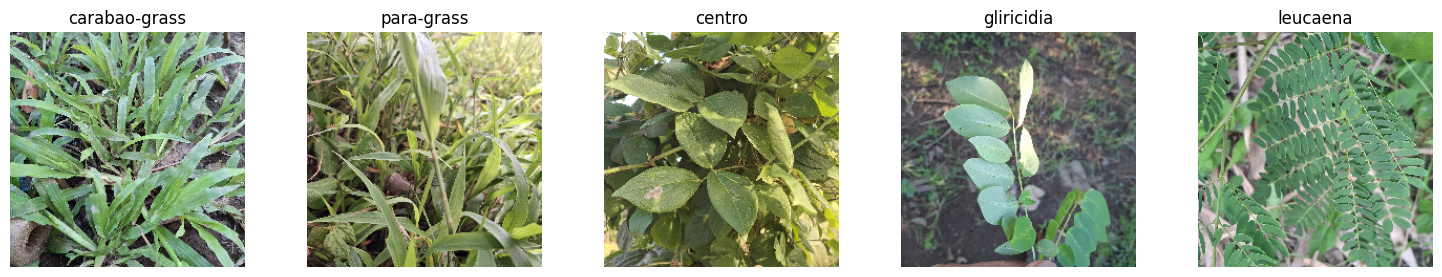

In [65]:
fig, ax = plt.subplots(1, 5, figsize=(15, 15))
fig.tight_layout()
selected_indices = []

# Get 10 random samples (2 per class for 5 classes)
for cls in range(len(classes)):
    # Find all indices where this class appears in TEST set
    class_indices = np.where(np.argmax(Y_test, axis=1) == cls)[0]

    random_indices = random.sample(list(class_indices), 1)
    selected_indices.extend(random_indices)

random.shuffle(selected_indices)

# Plot the selected samples
for ind, idx in enumerate(selected_indices[:5]):
    ax[ind].imshow(X_test[idx])
    ax[ind].set_title(f"{classes[np.argmax(Y_test[idx])]}")
    ax[ind].axis('off')

plt.show()

In [114]:
model = Sequential()

# Block 1
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

# Block 2
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

# Block 3
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

# Block 4
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.6))


# Top layers
model.add(Flatten())  # Better than Flatten for reducing params

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.6))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.6))
model.add(Dense(32, activation='relu'))
# model.add(Dropout(0.6))


model.add(Dense(5, activation = "softmax"))


model.summary()

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_76 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_71 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_106 (Dropout)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_77 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_72 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_107 (Dropout)           │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_78 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_73 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_108 (Dropout)           │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_79 (Conv2D)              │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_74 (MaxPooling2D) │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_109 (Dropout)           │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_68 (Dense)                │ (None, 256)            │    12,845,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_110 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_69 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_111 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_70 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_71 (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,270,917 (50.62 MB)

 Trainable params: 13,270,917 (50.62 MB)

 Non-trainable params: 0 (0.00 B)

In [115]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

model_checkpoint = ModelCheckpoint(
    filepath='/content/drive/MyDrive/Thesis/Dataset/new_best_model.keras',
    save_best_only=True,
    monitor='val_loss'
)


history = model.fit(
    X_train,
    Y_train,
    epochs=100,
    validation_data=(X_val, Y_val),
    callbacks=[early_stopping,model_checkpoint]
)

Epoch 1/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 12s 91ms/step - accuracy: 0.2058 - loss: 1.8947 - val_accuracy: 0.2373 - val_loss: 1.6030
Epoch 2/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - accuracy: 0.2246 - loss: 1.5845 - val_accuracy: 0.3390 - val_loss: 1.5382
Epoch 3/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - accuracy: 0.2869 - loss: 1.5277 - val_accuracy: 0.3390 - val_loss: 1.4343
Epoch 4/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - accuracy: 0.2837 - loss: 1.4999 - val_accuracy: 0.3390 - val_loss: 1.4283
Epoch 5/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 0.3211 - loss: 1.4845 - val_accuracy: 0.3390 - val_loss: 1.4220
Epoch 6/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - accuracy: 0.3047 - loss: 1.4870 - val_accuracy: 0.3559 - val_loss: 1.4216
Epoch 7/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.3254 - loss: 1.4717 - val_accuracy: 0.3220 - val_loss: 1.4517
Epoch 8/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 0.3006 - loss: 1.4849 - val_accuracy: 0

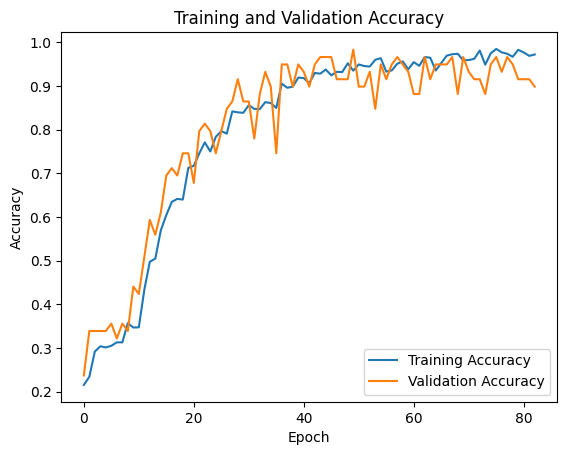

In [116]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')
plt.show()

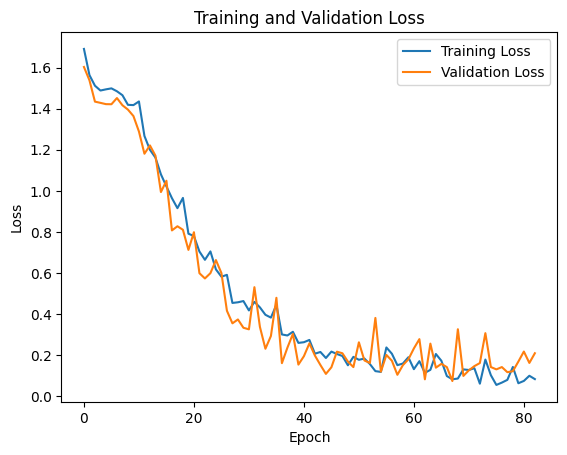

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9670 - loss: 0.0767


In [117]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
val_loss, val_acc = model.evaluate(X_val, Y_val)

In [118]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Thesis/Dataset/best_model.keras')

test_loss, test_acc = model.evaluate(X_test, Y_test)
print(f"Final Test Accuracy: {test_acc:.2f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 343ms/step - accuracy: 0.9245 - loss: 0.2364
Final Test Accuracy: 0.92


In [119]:
# Generate predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(Y_test, axis=1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 349ms/step


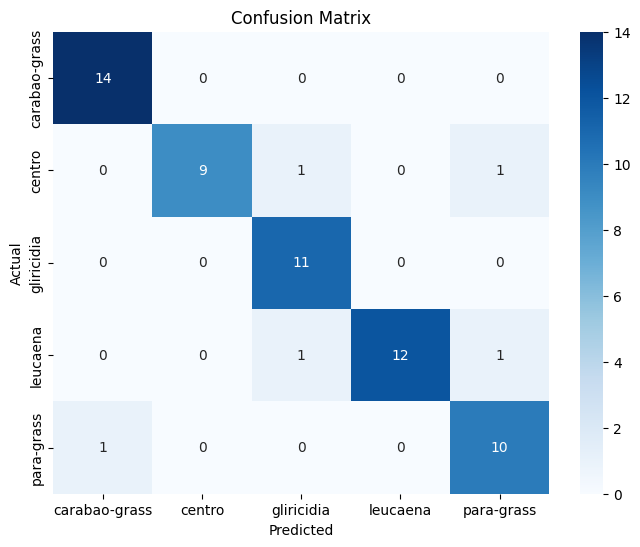

In [120]:
conf_matrix = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [121]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Thesis/Dataset/best_model.keras')

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('/content/drive/MyDrive/Thesis/Dataset/model.tflite', 'wb') as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmpwjnvou8p'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_18')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  132452493845776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132452493849232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132452493839248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132452493843664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132452493838288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132452493844432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132445808167248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132445808165136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132445808167632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132445808174544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132445808166